## Human Activity Recognition using KNN and PCA
- This notebook implements a full classification pipeline for human activity recognition using smartphone sensor data.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Load and Preprocess UCI HAR Dataset
- Reads the UCI HAR dataset, ensures feature names are unique, maps numeric activity labels to their names, merges training and test data with subjects and labels, and saves them as hartrain.csv and hartest.csv for easier analysis.

In [30]:
import pandas as pd
from collections import Counter

features = pd.read_csv("UCI HAR Dataset/features.txt", sep=r'\s+', header=None)
feature_names = features[1].tolist()

counts = Counter()
unique_feature_names = []
for name in feature_names:
    counts[name] += 1
    unique_feature_names.append(f"{name}_{counts[name]}" if counts[name] > 1 else name)

activity_labels = pd.read_csv("UCI HAR Dataset/activity_labels.txt", sep=r'\s+', header=None, index_col=0)


In [31]:
# Train data
X_train = pd.read_csv("UCI HAR Dataset/train/X_train.txt", sep=r'\s+', header=None, names=unique_feature_names)
y_train = pd.read_csv("UCI HAR Dataset/train/y_train.txt", header=None, names=["Activity"])
subject_train = pd.read_csv("UCI HAR Dataset/train/subject_train.txt", header=None, names=["Subject"])
y_train["Activity"] = y_train["Activity"].map(activity_labels[1])
train_df = pd.concat([X_train, y_train, subject_train], axis=1)
train_df.to_csv("hartrain.csv", index=False)

# Test data
X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", sep=r'\s+', header=None, names=unique_feature_names)
y_test = pd.read_csv("UCI HAR Dataset/test/y_test.txt", header=None, names=["Activity"])
subject_test = pd.read_csv("UCI HAR Dataset/test/subject_test.txt", header=None, names=["Subject"])
y_test["Activity"] = y_test["Activity"].map(activity_labels[1])
test_df = pd.concat([X_test, y_test, subject_test], axis=1)
test_df.to_csv("hartest.csv", index=False)


- This part displays how many samples belong to each activity class in the training and test datasets.

In [32]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain class distribution:\n", train_df['Activity'].value_counts())
print("\nTest class distribution:\n", test_df['Activity'].value_counts())


Train shape: (7352, 563)
Test shape: (2947, 563)

Train class distribution:
 Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Test class distribution:
 Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64


##  Split Features and Labels

In [33]:
X_train = train_df.drop(columns=['Activity', 'Subject'])
y_train = train_df['Activity']
X_test = test_df.drop(columns=['Activity', 'Subject'])
y_test = test_df['Activity']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##  PCA Dimensionality Reduction

We apply **Principal Component Analysis (PCA)** to reduce the number of features while preserving as much variance as possible.  
This helps in removing redundant information, speeding up computations, and avoiding the curse of dimensionality.

PCA transforms the original features into a new set of orthogonal components ranked by explained variance.

In [34]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


## K Optimization using GridSearchCV

In [35]:
param_grid = {'n_neighbors': range(1, 20)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_pca, y_train)

best_k = grid.best_params_['n_neighbors']
print("Best K value:", best_k)


Best K value: 14


- We train the K-Nearest Neighbors (KNN) classifier using the transformed training data to predict activity labels based on the majority vote of the nearest neighbors.

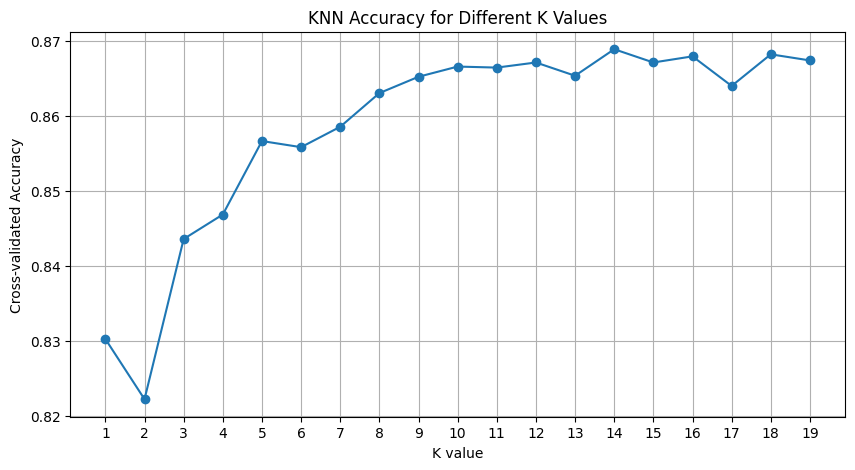

In [36]:
k_values = list(range(1, 20))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_pca, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

plt.figure(figsize=(10, 5))
plt.plot(k_values, cv_scores, marker='o')
plt.xticks(k_values)
plt.xlabel("K value")
plt.ylabel("Cross-validated Accuracy")
plt.title("KNN Accuracy for Different K Values")
plt.grid(True)
plt.show()


## Final Model with Best K and Evaluation

🎯 Test Accuracy: 0.8717339667458432
📋 Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      0.94      0.97       537
           SITTING       0.83      0.76      0.79       491
          STANDING       0.79      0.90      0.84       532
           WALKING       0.81      0.97      0.89       496
WALKING_DOWNSTAIRS       0.95      0.73      0.83       420
  WALKING_UPSTAIRS       0.90      0.89      0.90       471

          accuracy                           0.87      2947
         macro avg       0.88      0.87      0.87      2947
      weighted avg       0.88      0.87      0.87      2947



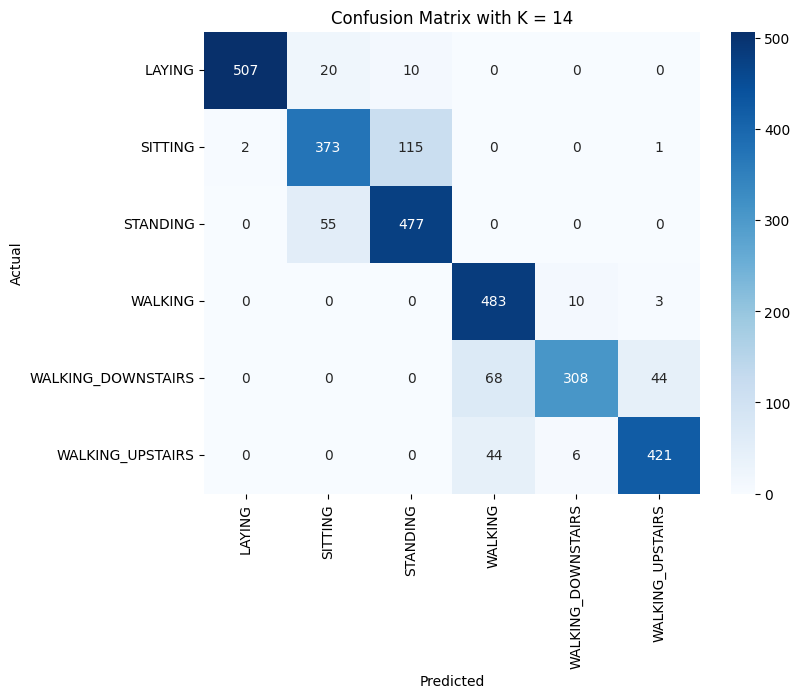

In [37]:

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_pca, y_train)
y_pred = best_knn.predict(X_test_pca)

print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix with K = {best_k}")
plt.show()
